In [2]:
pip install yfinance

     |████████████████████████████████| 6.3 MB 12.1 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=ab858d64a6245316a74e1770a2c45b54983a792c6f0a0b1b0d4f76449c4b51cb
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [35]:
import yfinance as yf

In [36]:
import numpy as np


In [37]:
df = yf.download('AAPL', start='2020-01-01')

[*********************100%***********************]  1 of 1 completed


In [38]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,74.096458,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,73.376076,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.960770,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,73.612915,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.797081,132079200


In [39]:
df['returns'] = np.log(df.Close.pct_change() + 1)

In [40]:
df['direction'] = [1 if i > 0 else -1 for i in df.returns]

In [44]:
def logit(df, lags):
  names = []
  for i in range(1 , lags + 1):
    df['Lag_'+ str(i)] = df['returns'].shift(i)
    df['Lag_'+ str(i) + '_dir'] = [1 if j > 0 else -1 for j in df['Lag_'+ str(i)]]
    names.append('Lag_'+ str(i) + '_dir')
  return names

In [45]:
dirnames = logit(df, 2)

In [46]:
dirnames

['Lag_1_dir', 'Lag_2_dir']

In [47]:
df.dropna(inplace=True)

In [48]:
from sklearn.linear_model import LogisticRegression

In [49]:
model = LogisticRegression()

In [50]:
model.fit(df[dirnames], df['direction'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
df['prediction_logit'] = model.predict(df[dirnames])

In [53]:
df['prediction_logit']

Date
2020-01-07   -1
2020-01-08    1
2020-01-09   -1
2020-01-10   -1
2020-01-13   -1
             ..
2021-09-29    1
2021-09-30   -1
2021-10-01    1
2021-10-04   -1
2021-10-05    1
Name: prediction_logit, Length: 441, dtype: int64

In [54]:
df['strat_logit'] = df['prediction_logit'] * df['returns']

In [56]:
np.exp(df[['returns', 'strat_logit']].sum())

returns        1.882722
strat_logit    2.777592
dtype: float64

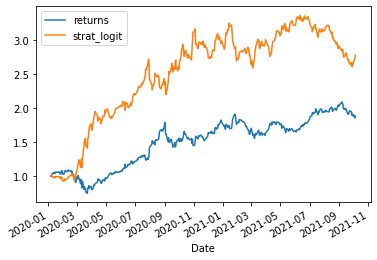

In [57]:
np.exp(df[['returns', 'strat_logit']].cumsum()).plot()

Model is overfitted due to using the same traininng and prediction data

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
train, test = train_test_split(df, shuffle = False, test_size = 0.25, random_state = 0)

In [60]:
train = train.copy()

In [61]:
test = test.copy()

In [62]:
model = LogisticRegression()

In [63]:
model.fit(train[dirnames], train['direction'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [64]:
test['prediction_logit'] = model.predict(test[dirnames])


In [67]:
test['strat_logit'] = test['prediction_logit'] * test['returns']

In [68]:
np.exp(test[['returns', 'strat_logit']].sum())

returns        1.056371
strat_logit    0.892349
dtype: float64

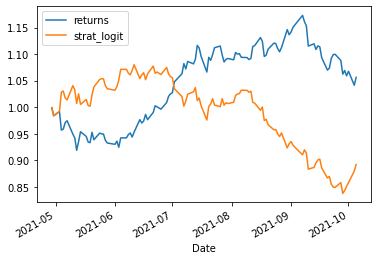

In [69]:
np.exp(test[['returns', 'strat_logit']].cumsum()).plot()

In [70]:
from sklearn import metrics

In [71]:
metrics.confusion_matrix(test['direction'], test['prediction_logit'])

array([[27, 25],
       [31, 28]])

In [72]:
print(metrics.classification_report(test['direction'], test['prediction_logit']))

              precision    recall  f1-score   support

          -1       0.47      0.52      0.49        52
           1       0.53      0.47      0.50        59

    accuracy                           0.50       111
   macro avg       0.50      0.50      0.50       111
weighted avg       0.50      0.50      0.50       111

